In [1]:
import os
import math
import random
import warnings
import numpy as np
import pandas as pd 
from sklearn import metrics
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
filespath="H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\liver"
protiens=[ x for x in os.listdir(filespath) if (".Quant.csv") in x]

res=pd.DataFrame()
for file in protiens:
    
    try:
        list(pd.read_csv(os.path.join(filespath,file), skiprows=1,index_col=False).Peptide)
        res=pd.concat([res,pd.read_csv(os.path.join(filespath,file), skiprows=1,index_col=False)])  
    except:
        list(pd.read_csv(os.path.join(filespath,file), skiprows=3,index_col=False).Peptide)
        res=pd.concat([res,pd.read_csv(os.path.join(filespath,file), skiprows=3,index_col=False)])  
        
        

In [3]:
res.shape

(27307, 204)

In [4]:
df=res.copy()
df.shape

(27307, 204)

In [19]:
temp=df[['Peptide',  ' Exchangeable Hydrogens', ' M0', ' M1', ' M2', ' M3', ' M4', ' M5']]
temp.columns=['Peptide',  'neh', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5']

temp['Peptide']=[x.upper() for x in temp['Peptide']]
temp=temp.sort_values(by='Peptide')
temp=temp.drop_duplicates('Peptide')
temp=temp.reset_index(drop=True)
temp.shape

(21619, 8)

In [20]:
temp.to_csv("selectedPep.csv",index=False)
temp.head()

,Peptide,neh,M0,M1,M2,M3,M4,M5
0,AAAADGEPLHNEEER,47,41.424,34.442,16.387,5.688,1.589,0.376
1,AAAAIMHM,22,57.822,25.788,11.769,3.499,0.894,0.188
2,AAAAPAAAATTAAPAAAAAPAK,72,35.992,35.157,18.796,7.179,2.176,0.554
3,AAAEVNQEYGLDPK,34,42.338,34.531,15.942,5.346,1.439,0.327
4,AAAFEDQENETVVVK,34,39.109,34.780,17.405,6.309,1.832,0.450


In [21]:
rate=[x for x in np.array(np.random.uniform(low = math.log(2)/31, high = math.log(2), size = temp.shape[0] )).ravel()]
temp['rate']=rate
temp.M0=temp.M0/100
temp.M1=temp.M1/100
temp.M2=temp.M2/100
temp.M3=temp.M3/100
temp.M4=temp.M4/100
temp.M5=temp.M5/100
temp.head()

,Peptide,neh,M0,M1,M2,M3,M4,M5,rate
0,AAAADGEPLHNEEER,47,0.41424,0.34442,0.16387,0.05688,0.01589,0.00376,0.212219
1,AAAAIMHM,22,0.57822,0.25788,0.11769,0.03499,0.00894,0.00188,0.348005
2,AAAAPAAAATTAAPAAAAAPAK,72,0.35992,0.35157,0.18796,0.07179,0.02176,0.00554,0.583089
3,AAAEVNQEYGLDPK,34,0.42338,0.34531,0.15942,0.05346,0.01439,0.00327,0.425599
4,AAAFEDQENETVVVK,34,0.39109,0.34780,0.17405,0.06309,0.01832,0.00450,0.667644


In [22]:
def compute_ioasym(i0,neh):
    pw=0.046
    ph=1.5574E-4
    return i0*(1-pw/(1-ph))**neh

def compute_i0_t(t,k,neh,i0):
    io_asym=compute_ioasym(i0,neh)
    return  io_asym + (i0-io_asym)*(math.exp(-k*t))

In [23]:
times=[0,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]


In [24]:
sim_res=[]
for i in range(len(temp)):
    temp_res=[temp.Peptide[i],temp.neh[i],temp.rate[i],temp.M0[i],temp.M1[i],temp.M2[i],temp.M3[i],temp.M4[i],temp.M5[i]]
    
    io_ts=[]
    io_ns=[] 
    for t in times:
        io_ts.append(compute_i0_t(t,temp.rate[i],temp.neh[i],temp.M0[i]))
        io_ns.append(float(io_ts[-1]+np.random.normal(0,0.01/12,1)))
        
    temp_res+=[metrics.r2_score(io_ns,io_ts),(metrics.mean_squared_error(io_ns,io_ts))**0.5]
    
    temp_res+=io_ts+io_ns
    sim_res.append(temp_res)
    

In [25]:
compute_i0_t(0,temp.rate[0],temp.neh[0],temp.M0[0])

0.41424

In [26]:
df_sim_res=pd.DataFrame(sim_res)
df_sim_res.columns=["Pep",'NEH','k','I0','I1','I2','I3','I4','I5','R2','RMSE']+ [f'T_i0_{t}' for t in times] +[f'N_i0_{t}' for t in times]

In [27]:
# plt.scatter([df_sim_res[f'T_i0_{t}'][0] for t in times],
#             [df_sim_res[f'N_i0_{t}'][0] for t in times])

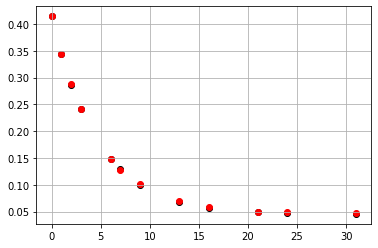

In [28]:
plt.scatter(times,[df_sim_res[f'T_i0_{t}'][0] for t in times],c='k')
plt.scatter(times,[df_sim_res[f'N_i0_{t}'][0] for t in times],c='r')
plt.grid()

In [29]:
df_sim_res.to_csv("NEH_sim.csv",index=False)

In [30]:
df_sim_res

,Pep,NEH,k,I0,I1,I2,I3,I4,I5,R2,...,N_i0_2,N_i0_3,N_i0_6,N_i0_7,N_i0_9,N_i0_13,N_i0_16,N_i0_21,N_i0_24,N_i0_31
0,AAAADGEPLHNEEER,47,0.212219,0.41424,0.34442,0.16387,0.05688,0.01589,0.00376,0.999948,...,0.287253,0.241147,0.147956,0.127761,0.100869,0.069338,0.059545,0.049612,0.048572,0.046804
1,AAAAIMHM,22,0.348005,0.57822,0.25788,0.11769,0.03499,0.00894,0.00188,0.999978,...,0.391308,0.337076,0.251672,0.237957,0.221818,0.209151,0.207292,0.206350,0.205777,0.205743
2,AAAAPAAAATTAAPAAAAAPAK,72,0.583089,0.35992,0.35157,0.18796,0.07179,0.02176,0.00554,0.999966,...,0.120713,0.073353,0.023113,0.017843,0.014802,0.013026,0.012698,0.011705,0.012942,0.013073
3,AAAEVNQEYGLDPK,34,0.425599,0.42338,0.34531,0.15942,0.05346,0.01439,0.00327,0.999932,...,0.229320,0.179700,0.111666,0.102073,0.094834,0.086783,0.086440,0.084989,0.086184,0.084916
4,AAAFEDQENETVVVK,34,0.667644,0.39109,0.34780,0.17405,0.06309,0.01832,0.00450,0.999891,...,0.159929,0.120294,0.085185,0.082454,0.080699,0.080376,0.079330,0.077462,0.077742,0.079320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21614,YYTSASGDEMVSLK,23,0.150376,0.39538,0.33180,0.17478,0.06866,0.02184,0.00588,0.999926,...,0.327625,0.301764,0.238976,0.224997,0.200355,0.171822,0.157698,0.144309,0.140657,0.136709
21615,YYVDVPQEEVPFR,25,0.304325,0.37084,0.35262,0.18292,0.06767,0.01984,0.00488,0.999864,...,0.252815,0.216878,0.155999,0.144607,0.130861,0.119837,0.115288,0.116299,0.113055,0.115405
21616,YYVGDTEDVLFEK,17,0.094601,0.39046,0.34947,0.17415,0.06255,0.01794,0.00434,0.999859,...,0.353162,0.335775,0.296507,0.285213,0.266853,0.237678,0.222534,0.205569,0.196263,0.187770
21617,YYVTIIDAPGHR,20,0.340575,0.42973,0.34925,0.15563,0.04960,0.01255,0.00266,0.999941,...,0.300244,0.262758,0.201711,0.192524,0.180564,0.170528,0.168890,0.168624,0.168871,0.167708
